# Time Syncing

The goal of this notebook is to find out whether the IMU-Position updates and the video stream are offset in terms of time difference. 
The data for this notebook has been collected via the data_gathering.py script.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

Load timestamp plus delta position from file

In [17]:
imu_timestamps = []
with open('./data/timestamps/series1.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        time_part = float(parts[0])
        delta_pos_part = float(parts[1])  
        imu_timestamps.append([time_part, delta_pos_part])
imu_timestamps[:5]

[[1720038513.7229583, 0.0],
 [1720038513.784253, 0.0],
 [1720038513.8396149, 0.0],
 [1720038513.896001, 0.0],
 [1720038513.9512756, 0.0]]

In [23]:
image_timestamps = []
image_dir = './data/images/calibration/series1/'
with open(image_dir + 'image_timestamps.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        time_part = float(parts[0])
        image_timestamps.append(time_part)

image_timestamps[:5]

[1720038513.6520603,
 1720038513.7269428,
 1720038513.7861218,
 1720038513.8408196,
 1720038513.8976247]

The timestamp-point is the the point in time they both are available in the main python process (here data_gathering.py)

We can see that the difference between the timestamps of imu_data and image_data that the imu-data is about 1 frame behind just from the logic within the main loop. However there may be a delay associated with the videostream which could also play a role.

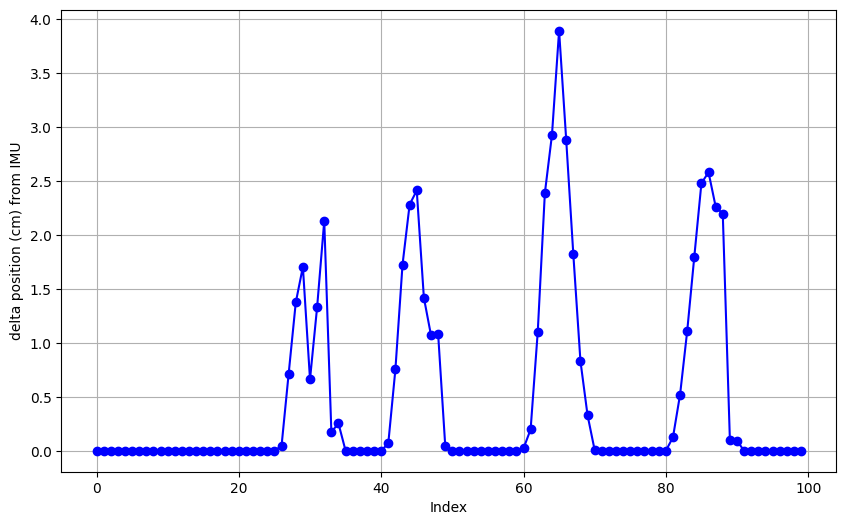

In [25]:

values = [pair[1] for pair in imu_timestamps[:100]]
indices = range(len(imu_timestamps[:100]))


plt.figure(figsize=(10, 6))
plt.plot(indices, values, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('delta position (cm) from IMU')
plt.grid(True)
plt.show()

From this chart we can infer that the first visible movement in the images should be at index 26 or 27 and end about 10 frames later.

In [46]:
images = []  
image_filenames = os.listdir(image_dir)

for filename in image_filenames:
    if filename.endswith(".png"):  
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)
        images.append(image)

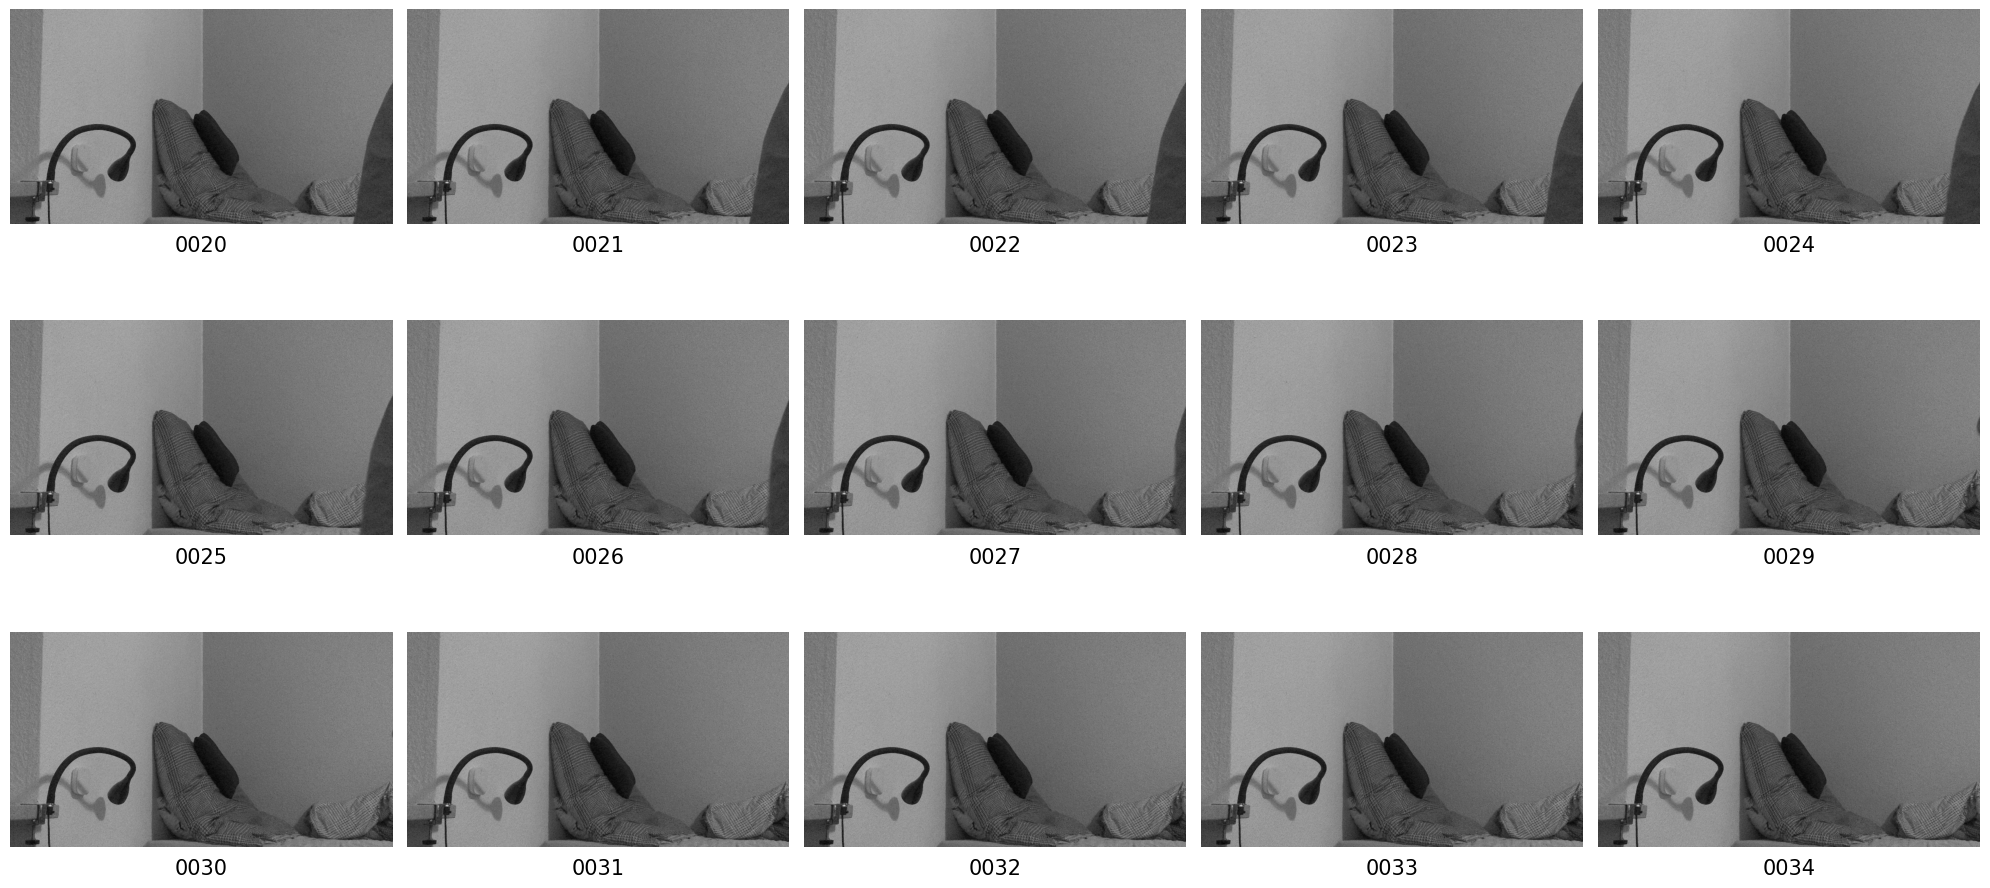

In [51]:
n = 5  # number of columns

plt.figure(figsize=(20, 10))  
start = 20
end = 35

relevant_images = images[start:end]
relevant_image_filenames = image_filenames[start:end]

for i, (image, filename) in enumerate(zip(relevant_images, relevant_image_filenames)):
    plt.subplot((len(relevant_images) + n - 1) // n, n, i + 1)  
    plt.imshow(image, cmap='gray')  
    plt.text(0.5, -0.1,filename[-8:-4], fontsize=15, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

As one can clearly see, there is no movement in the specified frames. (Please ignore the unmade bed though, it was late ;) )

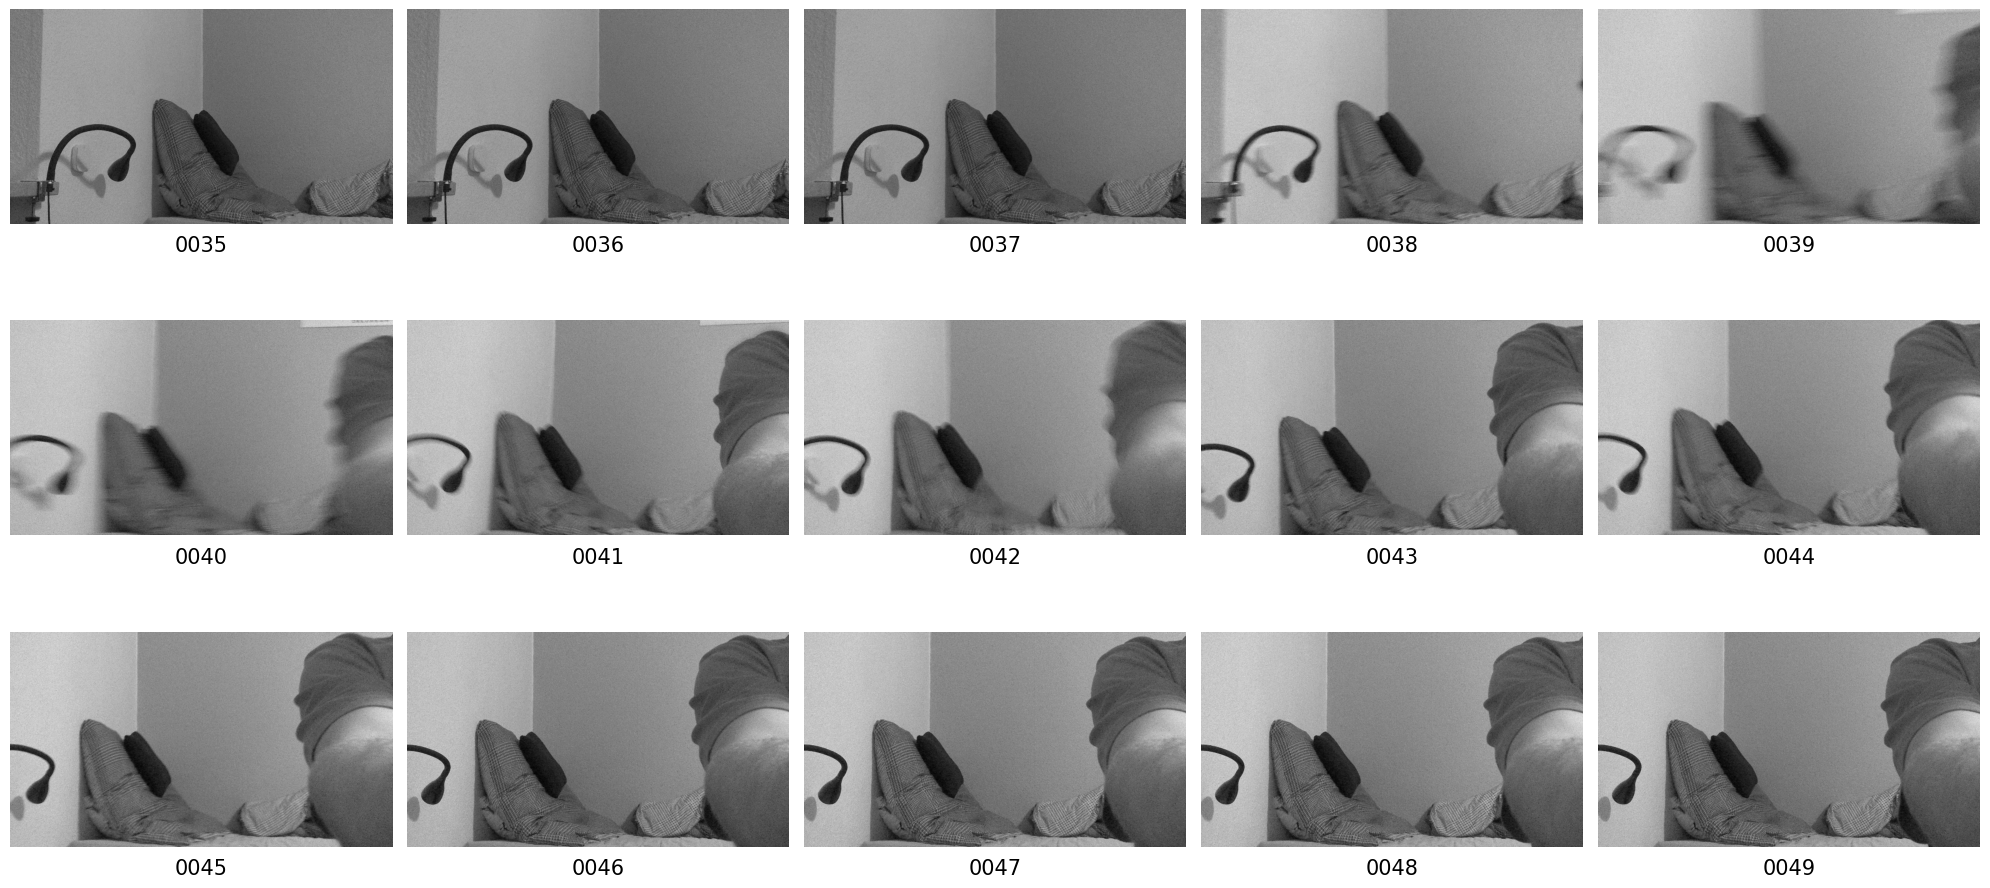

In [52]:
n = 5  # number of columns

plt.figure(figsize=(20, 10))  

start = 35
end = 50

relevant_images = images[start:end]
relevant_image_filenames = image_filenames[start:end]

for i, (image, filename) in enumerate(zip(relevant_images, relevant_image_filenames)):
    plt.subplot((len(relevant_images) + n - 1) // n, n, i + 1)  
    plt.imshow(image, cmap='gray')  
    plt.text(0.5, -0.1,filename[-8:-4], fontsize=15, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

The blurring starts lightly in Frame 38. and it ends in 46. (not really visible in the plot but if you look at the images in big, image 44 and 45 are still slightly blurred). So the camera frame is around 12 Frames behind the IMU Information.

This also means that the movement period in the camera (frame 38 to 46 -> 9 Frames with movement between the previous frame and the current frame) is the same as the one for the IMU measurements with 9 values which are non 0 for this "event". At least the movement length seems to be synced. 


Let's confirm the hypothesis of 12 frames offset and look at the Movement from IMU-Index 60 to 69/70 for another sample.  

For that, we'll start around camera frame 68 onwards. (this is the 12 Frames delta inbetween camera and imu measurements, minus some frames for possible other inaccuracies)

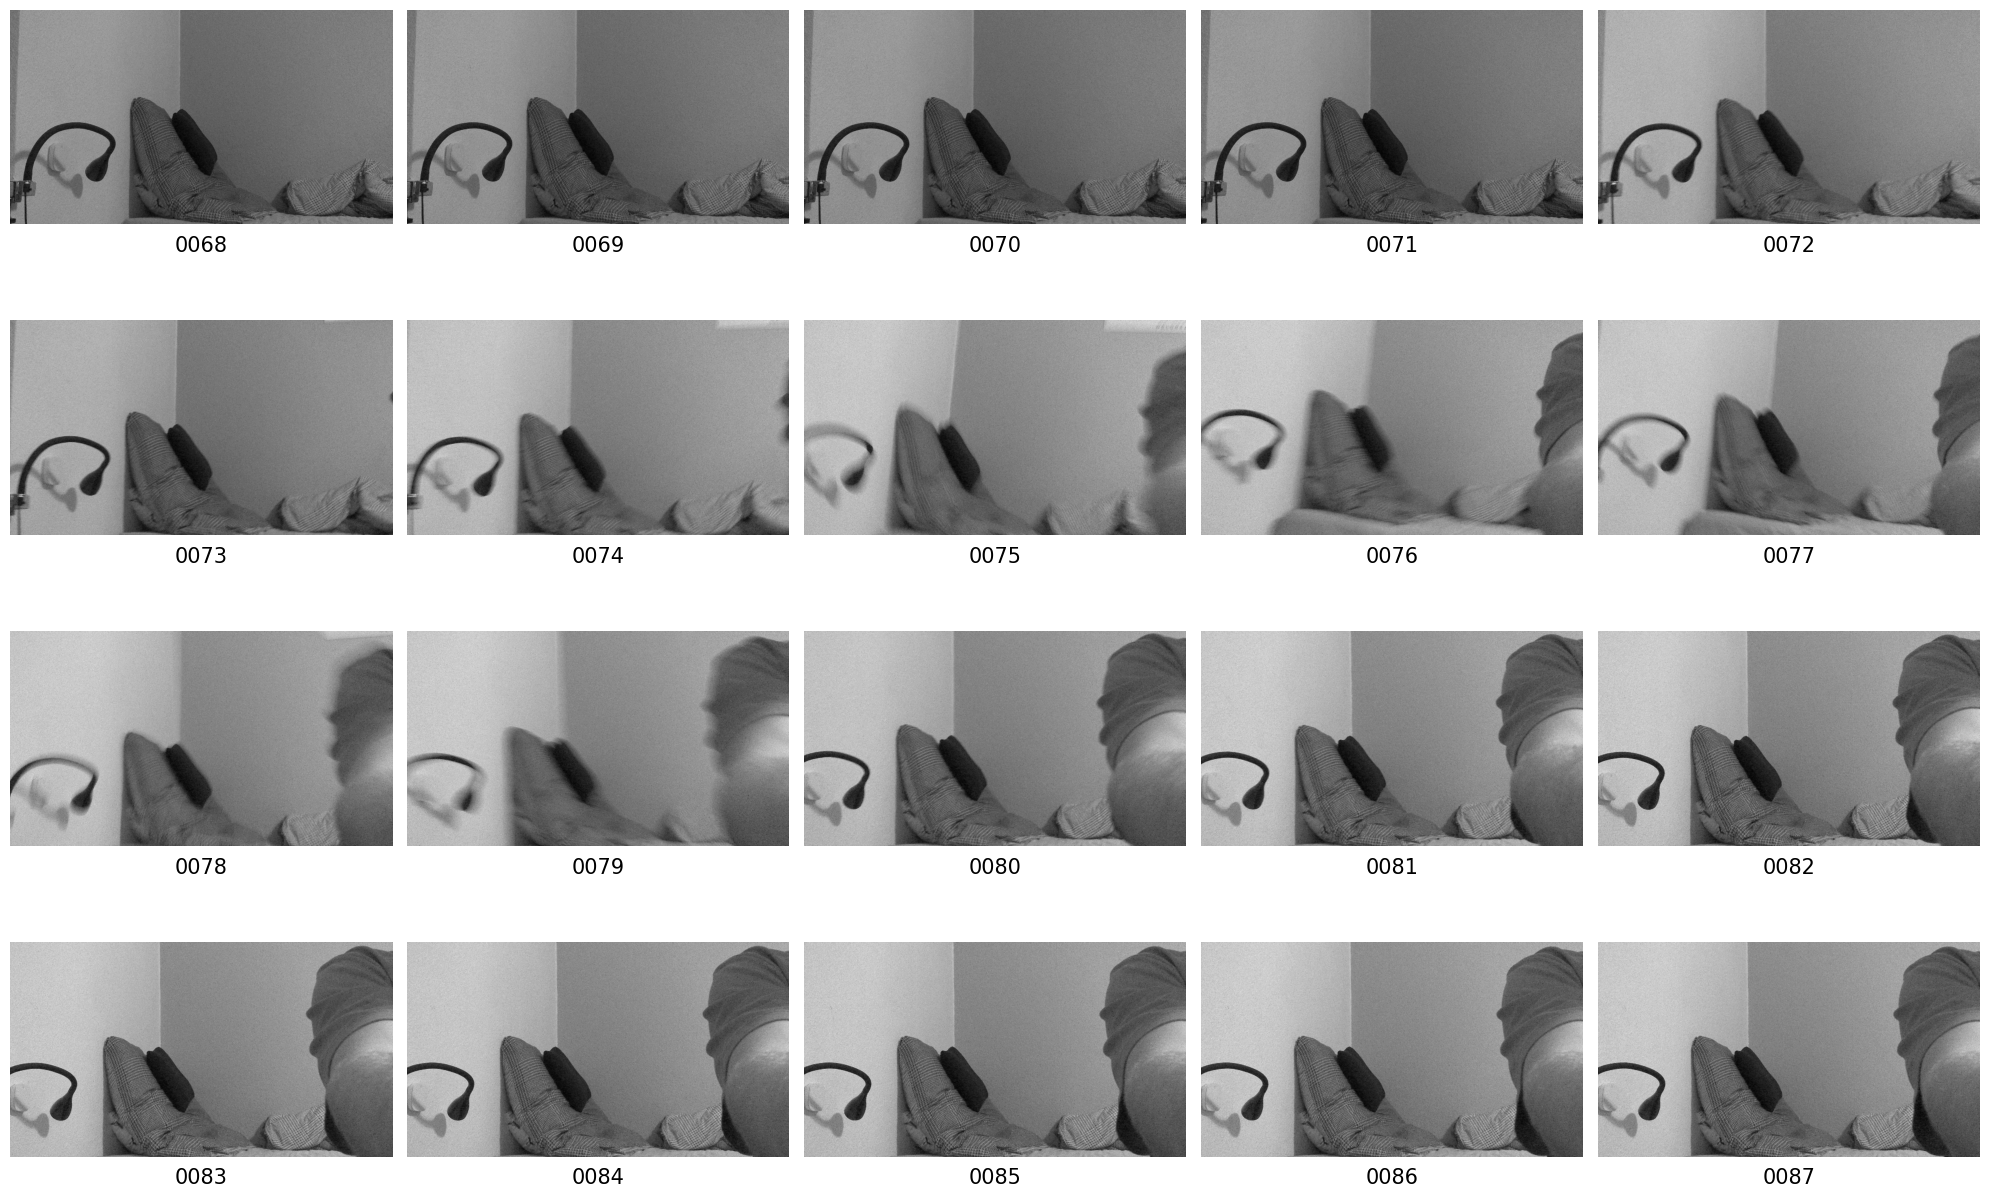

In [57]:
n = 5  # number of columns

plt.figure(figsize=(20, 13))  

start = 68
end = 88

relevant_images = images[start:end]
relevant_image_filenames = image_filenames[start:end]

for i, (image, filename) in enumerate(zip(relevant_images, relevant_image_filenames)):
    plt.subplot((len(relevant_images) + n - 1) // n, n, i + 1)  
    plt.imshow(image, cmap='gray')  
    plt.text(0.5, -0.1,filename[-8:-4], fontsize=15, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

Slight movement starts inbetween frame 71 and frame 72 (again, review full size image for that). After that, it keeps going until frame 82. After that, there is no movement in the frames anymore.

So all in all, while not perfect the movement length here (11) was roughly equal to the one measured by the IMU (10 or 11 depending on whether to count the almost 0 value at 71)

The offset again was 12 from the first measured IMU-Movement (60) and the first frame which was blurred (72).

# Takeaways from this notebook:

The camera has almost half a second delay (30 fps and 12 frames behind) compared to the IMU.

This means for the VIO Implementation, we have to cache the imu-Frames for 12 loop iterations before we can start fusing the information.

In [5]:
import numpy as np
import matplotlib.pyplot as plt


In [38]:
imu_timestamps = []
imu_path = './data/timestamps/series1.txt'
imu_path = 'C:/Users/stern/Desktop/recordings/series9/imu_data.txt'
imu_path = './data/recordings/series21/imu_data.txt'
with open(imu_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        time_part = float(parts[0])
        delta_pos_part = float(parts[1])  
        yaw = float(parts[2])
        imu_timestamps.append([time_part, delta_pos_part, yaw])
for data in enumerate(imu_timestamps[:25]):
    print(data)

(0, [1720205694.9833193, 0.0, -20.882604140512697])
(1, [1720205695.0383039, 0.0, -20.767394357740148])
(2, [1720205695.094292, 0.0, -20.75304148555576])
(3, [1720205695.143634, 0.0, -20.586974924183668])
(4, [1720205695.193279, 0.0, -20.53864759285844])
(5, [1720205695.2427754, 0.0, -20.556009195106068])
(6, [1720205695.2931492, 0.0, -20.387251422083036])
(7, [1720205695.3419812, 0.0, -20.247629772862442])
(8, [1720205695.391797, 0.0, -20.18813432063651])
(9, [1720205695.4410617, 0.0, -20.145116901773534])
(10, [1720205695.496654, 0.0, -19.979569292104053])
(11, [1720205695.5464354, 0.0, -20.037297303535997])
(12, [1720205695.6016076, 0.0, -20.16028212322776])
(13, [1720205695.6516776, 0.0, -20.354093542675002])
(14, [1720205695.7068386, 0.0, -20.660645705536236])
(15, [1720205695.7566788, 0.0, -20.84759885496207])
(16, [1720205695.8122668, 0.0, -21.139815106814144])
(17, [1720205695.8676996, 0.0, -21.40923813116937])
(18, [1720205695.9174185, 0.0, -21.388451581912598])
(19, [17202056

In [39]:
imu_yaw_arr = np.array(imu_timestamps)[:,2]
imu_yaw_arr

array([-20.88260414, -20.76739436, -20.75304149, -20.58697492,
       -20.53864759, -20.5560092 , -20.38725142, -20.24762977,
       -20.18813432, -20.1451169 , -19.97956929, -20.0372973 ,
       -20.16028212, -20.35409354, -20.66064571, -20.84759885,
       -21.13981511, -21.40923813, -21.38845158, -21.1775392 ,
       -21.08091489, -21.21256868, -21.09851689, -20.95546687,
       -20.91810377, -21.06062365, -21.15976124, -21.21904823,
       -21.28412879, -21.38549989, -21.23397568, -21.17221574,
       -21.08147236, -21.12973495, -21.23551264, -21.31541094,
       -21.5417749 , -21.85372463, -22.14602002, -22.28416447,
       -22.24839106, -22.17214364, -22.13787343, -22.25261775,
       -22.40690825, -22.6118695 , -22.8184869 , -22.89208017,
       -23.01719759, -23.23808303, -23.45166244, -23.48681125,
       -23.19028064, -22.62723425, -22.17492146, -21.67150012,
       -21.44194695, -21.52859227, -21.83891078, -22.24836445,
       -22.71554213, -23.24941293, -23.71505964, -24.05

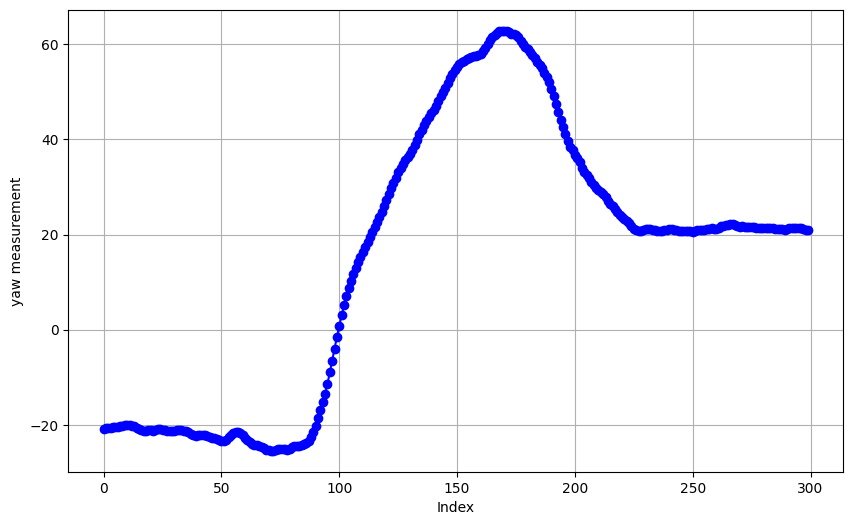

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(imu_yaw_arr)), imu_yaw_arr, marker='o', linestyle='-', color ='b')
plt.xlabel('Index')
plt.ylabel('yaw measurement')
plt.grid(True)
plt.show()

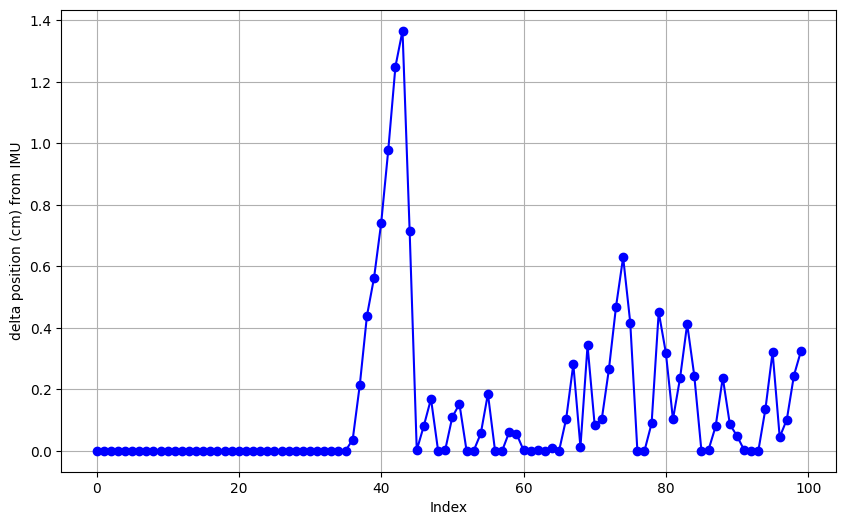

In [41]:

values = [pair[1] for pair in imu_timestamps[:100]]
indices = range(len(imu_timestamps[:100]))


plt.figure(figsize=(10, 6))
plt.plot(indices, values, marker='o', linestyle='-', color ='b')
plt.xlabel('Index')
plt.ylabel('delta position (cm) from IMU')
plt.grid(True)
plt.show()